In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import bar_chart_race as bcr

from datetime import datetime
from pytz import timezone

In [2]:
data_dir = '/Users/Karolina/ProjectsDataScience/data_science_environment/data/'
file_list = ['MyDataSpotify/StreamingHistory1.json',
             'MyDataSpotify/StreamingHistory2.json',
             'MyDataSpotify/StreamingHistory3.json',
             'MyDataSpotify/StreamingHistory4.json']

dfs = [] # an empty list to store the data frames
for file in file_list:
    data = pd.read_json(data_dir+file) # read data frame from json file
    dfs.append(data) # append the data frame to the list

df = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.

In [3]:
df.head()

,endTime,artistName,trackName,msPlayed
0,2021-01-23 14:36,Billie Eilish,Lo Vas A Olvidar (with ROSALÍA),203464
1,2021-01-23 14:39,Billie Eilish,Lo Vas A Olvidar (with ROSALÍA),203464
2,2021-01-23 14:43,Billie Eilish,Lo Vas A Olvidar (with ROSALÍA),203464
3,2021-01-23 14:46,Billie Eilish,Lo Vas A Olvidar (with ROSALÍA),203464
4,2021-01-23 14:50,Billie Eilish,Lo Vas A Olvidar (with ROSALÍA),203464


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37735 entries, 0 to 37734
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     37735 non-null  object
 1   artistName  37735 non-null  object
 2   trackName   37735 non-null  object
 3   msPlayed    37735 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [5]:
#double checking for duplicates
df.duplicated().sum()

0

In [6]:
df.endTime = pd.to_datetime(df.endTime, infer_datetime_format=True) 

In [7]:
#Set the current time to US Pacific timezone
df['endTimeTz']= df.endTime.dt.tz_localize(tz='UTC')

#convert US Pacific to Europe/Berlin Timezone
df['endTimeTzEU']=df.endTimeTz.dt.tz_convert(tz='Europe/Berlin')


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37735 entries, 0 to 37734
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype                        
---  ------       --------------  -----                        
 0   endTime      37735 non-null  datetime64[ns]               
 1   artistName   37735 non-null  object                       
 2   trackName    37735 non-null  object                       
 3   msPlayed     37735 non-null  int64                        
 4   endTimeTz    37735 non-null  datetime64[ns, UTC]          
 5   endTimeTzEU  37735 non-null  datetime64[ns, Europe/Berlin]
dtypes: datetime64[ns, Europe/Berlin](1), datetime64[ns, UTC](1), datetime64[ns](1), int64(1), object(2)
memory usage: 1.7+ MB


In [9]:
weekly = df.groupby([pd.Grouper(key='endTime', freq='W'),'artistName'])['trackName'].size().reset_index()
weekly['no_csum'] = weekly.groupby(['artistName'])['trackName'].cumsum()


#choosing only top5 artist in a given week
weekly5 = weekly.set_index(['endTime', 'artistName']).groupby(level=0, group_keys=False)['no_csum'].nlargest(5)

#reformatting the data into format suitable for the bar_chart_race package
weekly5_u = weekly5.unstack()
weekly5_u.fillna(method='ffill', inplace=True)
weekly5_u.fillna(0, inplace=True)

In [110]:
%%time
# help(bcr.bar_chart_race)
bcr.bar_chart_race(df=weekly5_u, n_bars=5, title='bla', period_length=400, cmap='dark12')

/opt/anaconda3/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
/opt/anaconda3/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))
/opt/anaconda3/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:226: UserWarning: Some of your columns never make an appearance in the animation. To reduce color repetition, set `filter_column_colors` to `True`
  warnings.warn("Some of your columns never make an appearance in the animation. "


CPU times: user 25.4 s, sys: 5.87 s, total: 31.3 s
Wall time: 40.4 s


In [10]:
weekly_time = df.groupby([pd.Grouper(key='endTime', freq='W'),'artistName'])['msPlayed'].sum().reset_index()
weekly_time['no_csum'] = weekly_time.groupby(['artistName'])['msPlayed'].cumsum()

weekly_time = weekly_time.loc[weekly_time['artistName']!= 'Justin Bieber']




#choosing only top5 artist in a given week
weekly_time5 = weekly_time.set_index(['endTime', 'artistName']).groupby(level=0, group_keys=False)['no_csum'].nlargest(10)

#reformatting the data into format suitable for the bar_chart_race package
weekly_time5_u = weekly_time5.unstack()
weekly_time5_u.fillna(method='ffill', inplace=True)
weekly_time5_u.fillna(0, inplace=True)

CPU times: user 1min 6s, sys: 10.9 s, total: 1min 17s
Wall time: 1min 44s


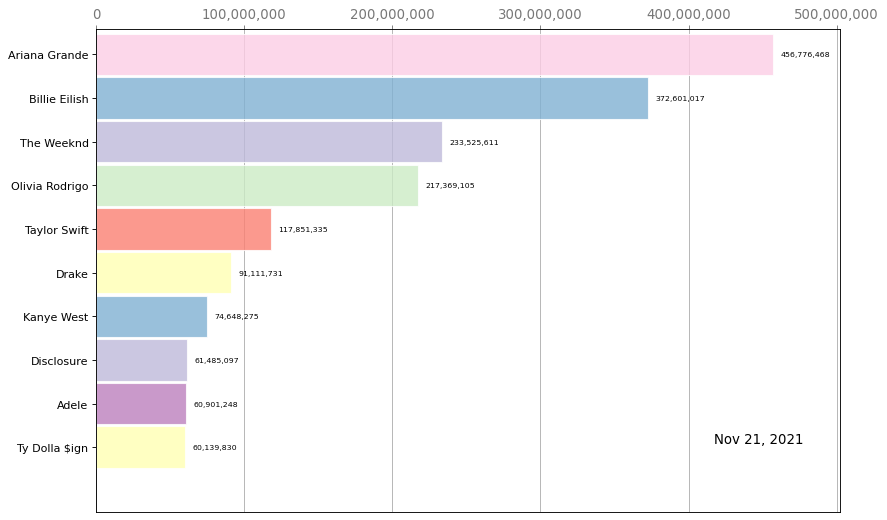

In [57]:
%%time
# help(bcr.bar_chart_race)

#initiate fig
fig, ax = plt.subplots(figsize=(12,8), facecolor='white', dpi= 80)

ax.margins(0, 0.01)
ax.set_axisbelow(True)

#ticks
ax.grid(which='major', axis='x', linestyle='-')
ax.tick_params(axis='x', colors='#777777', labelsize=12)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_ticks_position('top')


bcr.bar_chart_race(df=weekly_time5_u, 
                   n_bars=10, 
                   fig=fig, 
                   period_length=400, 
                   cmap='Set3_r',
                   period_fmt='%b %-d, %Y',
                   title='The most listened artists in 2021', 
                   title_size='smaller',
                   filter_column_colors=True)

In [13]:
weekly_time.loc[weekly_time['artistName']!= 'Justin Bieber']

,endTime,artistName,msPlayed,no_csum
0,2021-01-24,AaRON,255453,255453
1,2021-01-24,Academy Chamber Choir,484453,484453
2,2021-01-24,Alexandra Steliski,170156,170156
3,2021-01-24,Andy Stringer,4477,4477
4,2021-01-24,Arden Forest,113909,113909
...,...,...,...,...
7932,2021-11-21,Travis Scott,692012,8430059
7933,2021-11-21,Two Feet,83302,16545811
7934,2021-11-21,Tyga,232932,8965742
7935,2021-11-21,Unknown Mortal Orchestra,22203,252350


In [20]:
help(bcr.bar_chart_race)

Help on function bar_chart_race in module bar_chart_race._make_chart:

bar_chart_race(df, filename=None, orientation='h', sort='desc', n_bars=None, fixed_order=False, fixed_max=False, steps_per_period=10, period_length=500, interpolate_period=False, label_bars=True, bar_size=0.95, period_label=True, period_fmt=None, period_summary_func=None, perpendicular_bar_func=None, figsize=(6, 3.5), cmap=None, title=None, title_size=None, bar_label_size=7, tick_label_size=7, shared_fontdict=None, scale='linear', writer=None, fig=None, dpi=144, bar_kwargs=None, filter_column_colors=False)
    Create an animated bar chart race using matplotlib. Data must be in 
    'wide' format where each row represents a single time period and each 
    column represents a distinct category. Optionally, the index can label 
    the time period.
    
    Bar height and location change linearly from one time period to the next.
    
    If no `filename` is given, an HTML string is returned, otherwise the 
    animat

In [13]:
test = weekly_time5_u[43:]

In [14]:
x = test.transpose().reset_index()

In [52]:
x.columns=[ 'artistName', 'nr']
x.sort_values(by='nr', ascending=True, inplace=True)
x

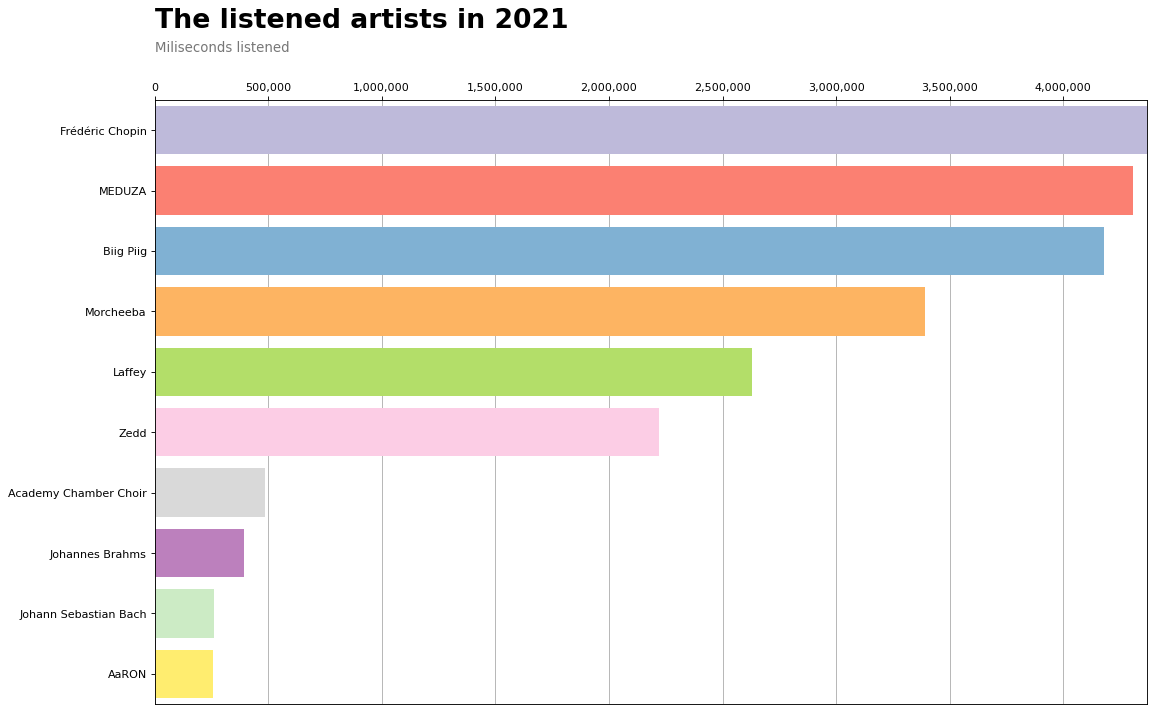

In [58]:
fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
my_cmap = plt.get_cmap("Set3_r")

ax.barh(x['artistName'], x['nr'], color=my_cmap.colors)

ax.margins(0, 0.01)
ax.set_axisbelow(True)

#ticks
ax.grid(which='major', axis='x', linestyle='-')
#ax.tick_params(axis='x', colors='#777777', labelsize=12)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_ticks_position('top')

#text
ax.text(0, 1.12, 'The listened artists in 2021',
            transform=ax.transAxes, size=24, weight=600, ha='left')
ax.text(0, 1.08, 'Miliseconds listened', transform=ax.transAxes, size=12, color='#777777')


plt.show()

CPU times: user 52.8 s, sys: 7.74 s, total: 1min
Wall time: 1min 3s


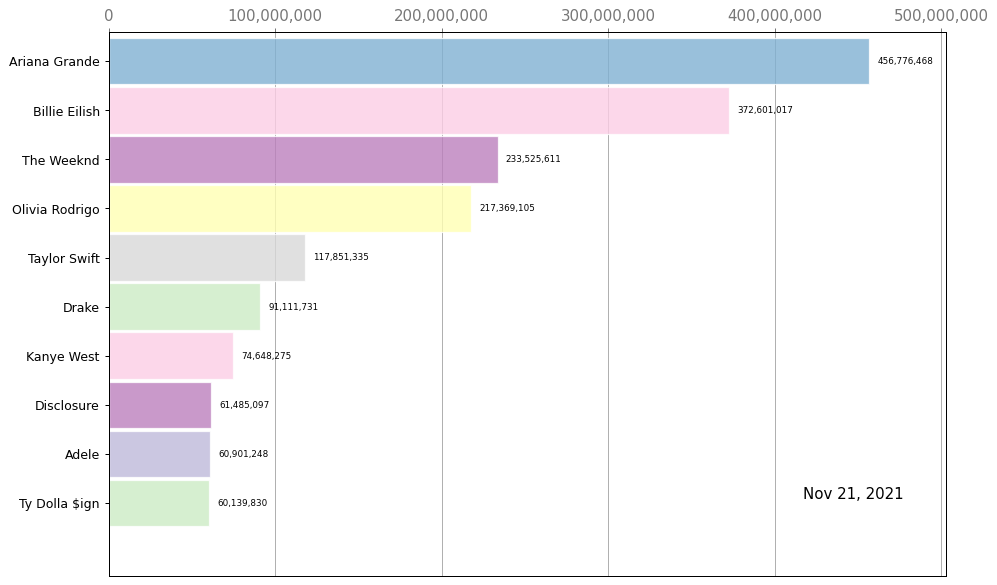

In [51]:
%%time

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,8), facecolor='white', dpi= 90)
    ax.margins(0, 0.01)
    ax.set_axisbelow(True)

    #ticks
    ax.grid(which='major', axis='x', linestyle='-')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')


bcr.bar_chart_race(df=weekly_time5_u, 
                   n_bars=10, 
                   fig=fig, 
                   period_length=400, 
                   cmap='Set3',
                   period_fmt='%b %-d, %Y',
                   title='The most listened artists in 2021', 
                   title_size='smaller',
                   filter_column_colors=True)